# Python codes for [Introduction to Computional Stochastic PDEs, CUP 2014](http://www.cambridge.org/gb/academic/subjects/mathematics/differential-and-integral-equations-dynamical-systems-and-co/introduction-computational-stochastic-pdes?format=PB&isbn=9780521728522)

[T. Shardlow](http://people.bath.ac.uk/tjs42/) Dec 2015
# Chapter 7





In [1]:
# load standard set of Python modules
from __future__ import (absolute_import, division,
                        print_function, unicode_literals)
import sys
if sys.version_info < (3,):
    try:
        from builtins import (bytes, dict, int, list, object, range, str,
                              ascii, chr, hex, input, next, oct, open,
                              pow, round, super, filter, map, zip)
        from future.builtins.disabled import (apply, cmp, coerce, execfile,
                                              file, long, raw_input,
                                              reduce, reload,
                                              unicode, xrange, StandardError)
    except:
        print("need future module")

In [2]:
from math import *
# Numpy
import numpy as np
from numpy import matlib
# Plotting
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
# Scipy
import scipy
from scipy import sparse
from scipy.sparse import linalg
from scipy import optimize
#
fft2=np.fft.fft2
ifft2=np.fft.ifft2

The circulant-embedding method also works for stationary random fields.

In [3]:
def circ_cov_sample_2d(C_red,n1,n2):
    """
    A7.1 Page 271
    """
    N=n1 * n2
    Lam=N * ifft2(C_red)
    d=np.ravel(np.real(Lam))
    d_minus=np.maximum(- d,0)
    if (np.max(d_minus) > 0):
        print('Invalid covariance rho(D_minus)={x:4.5f}'.format(x=np.max(d_minus)))
    xi=np.random.randn(n1,n2) + 1j*np.random.randn(n1,n2)
    V=(Lam ** 0.5)*xi
    Z=fft2(V) / sqrt(N)
    Z=np.ravel(Z);     X=np.real(Z);    Y=np.imag(Z)
    return X,Y

Here we calculate the reduced form of the stationary covariance matrix.

In [4]:
def reduced_cov(n1,n2,dx1,dx2,fhandle):
    """
    A7.2 Page 277
    """
    C_red=np.zeros((2 * n1 - 1,2 * n2 - 1))
    for i in range(2 * n1 - 1):
        for j in range(2 * n2 - 1):
            C_red[i,j]=fhandle((i+1 - n1) * dx1,(j+1 - n2) * dx2)
    return C_red

We give an example for the following Gaussian covariance.

In [5]:
from numba import jit, f8
@jit([f8(f8,f8,f8,f8,f8)])
def gaussA_exp(x1,x2,a11,a22,a12):
    """
    A7.3 Page 278
    """
    c=exp(- ((x1 ** 2 * a11 + x2 ** 2 * a22) - 2 * x1 * x2 * a12))
    return c
#
fhandle=jit(f8(f8,f8))(lambda x1,x2:gaussA_exp(x1,x2,1.,1.,0.5))
C_red=reduced_cov(3,2,1/2,1,fhandle)
print(C_red)

[[ 0.36787944  0.36787944  0.04978707]
 [ 0.47236655  0.77880078  0.17377394]
 [ 0.36787944  1.          0.36787944]
 [ 0.17377394  0.77880078  0.47236655]
 [ 0.04978707  0.36787944  0.36787944]]


The circulant embedding of the covariance matrix is achieved as follows.

In [6]:
def circ_embed_sample_2d(C_red,n1,n2):
    """
    A7.4 Page 279
    """
    N=n1 * n2
    tilde_C_red=np.zeros((2 * n1,2 * n2))
    tilde_C_red[1:2 * n1,1:2 * n2]=C_red
    tilde_C_red=np.fft.fftshift(tilde_C_red)
    u1,u2=circ_cov_sample_2d(tilde_C_red,2 * n1,2 * n2)
    u1=np.ravel(u1);  u2=np.ravel(u2)
    u1=u1[0:2*n1*n2]; u1=u1.reshape((n1,2 * n2)); u1=u1[:,::2]
    u2=u2[0:2*n1*n2]; u2=u2.reshape((n1,2 * n2)); u2=u2[:,::2]
    return u1,u2

Here's a small example of circulant embedding at work.

In [7]:
C_red=np.array([[1, 0.5, 0.5],
                [0.2, 0.1,0.2],
                [0.2,0.2,0.1]])
X,Y=circ_cov_sample_2d(C_red,3,3)
print(X,"\n",Y)

[-0.20812589 -0.17116355 -0.57732171 -1.5799635  -1.82330876 -2.97694882
  0.19581144 -1.81412841 -0.71615302] 
 [-0.3220219   0.28427941 -0.28740306 -0.2023154  -1.18786166 -0.3711384
  0.44576957 -0.71584397  0.36588286]


For a more interesting example, we generate samples of the mean-zero stationary random field with the separable exponential covariance.

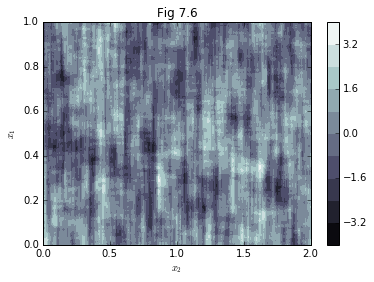

In [8]:
def sep_exp(x1,x2,ell_1,ell_2):
    """
    A7.5 Page 279
    """
    c=exp(- abs(x1) / ell_1 - abs(x2) / ell_2)
    return c
#
fhandle1=lambda x1,x2:sep_exp(x1,x2,1/5,1/10)
C_red=reduced_cov(201,401,1/200,1/200,fhandle1)
u1,u2=circ_embed_sample_2d(C_red,201,401)
#
ax = plt.gca()
x=np.linspace(0,1,201)
y=np.linspace(0,2,401)
CS=ax.contourf(y,x,u1,10,cmap=plt.cm.bone)
s=ax.set_xlabel(r'$x_2$')
s=ax.set_ylabel(r'$x_1$')
s=ax.set_title(r'Fig 7.6')
s=plt.colorbar(CS)

Here's an implementation of circulant embedding with padding.

In [9]:
def circ_embed_sample_2dB(C_red,n1,n2,m1,m2):
    """
    A7.6 Page 282
    """
    nn1=n1 + m1;    nn2=n2 + m2
    N=nn1 * nn2
    tilde_C_red=np.zeros((2 * nn1,2 * nn2))
    tilde_C_red[1:2 * nn1,1:2 * nn2]=C_red
    tilde_C_red=np.fft.fftshift(tilde_C_red)
    u1,u2=circ_cov_sample_2d(tilde_C_red,2 * nn1,2 * nn2)
    u1=np.ravel(u1);    u2=np.ravel(u2)
    u1=u1[0:2 * nn1 * n2];    u1=u1.reshape((nn1,2 * n2));    u1=u1[0:n1,::2]
    u2=u2[0:2 * nn1 * n2];    u2=u2.reshape((nn1,2 * n2));    u2=u2[0:n1,::2]
    return u1,u2

The last example with circulant embedding shows that the embedding has negative eigenvalues.

Invalid covariance rho(D_minus)=0.06464


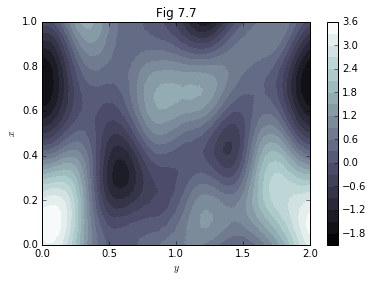

In [10]:
fhandle=lambda x1,x2:gaussA_exp(x1,x2,10,10,0)
#
n1=257; n2=257; m1=0;m2=0; dx1=1/(n1-1); dx2=1/(n2-1)
C_red=reduced_cov(n1+m1,n2+m2,dx1,dx2,fhandle)
u1,u2=circ_embed_sample_2dB(C_red,n1,n2,m1,m2)
#
ax = plt.gca()
x=np.linspace(0,1,n1); y=np.linspace(0,2,n2)
#ax.plot_wireframe(T,X,ut,rstride=16,cstride=1000,colors='k')
CS=ax.contourf(y,x,u1,20,cmap=plt.cm.bone)
#ax.set_zlabel(r'$u$')
s=ax.set_xlabel(r'$y$')
s=ax.set_ylabel(r'$x$')
s=ax.set_title(r'Fig 7.7')
s=plt.colorbar(CS)

The next set of codes developing the turning-bands method.

In [11]:
def turn_band_simple(grid1,grid2):
    """
    A7.7 Page 285
    """
    theta=2 * pi * np.random.uniform()
    e=np.array([cos(theta),sin(theta)])
    xx,yy=np.meshgrid(grid1,grid2)
    tt=np.dot(e,np.vstack([xx.ravel(),yy.ravel()]))
    xi=np.random.randn(2)
    v=sqrt(1 / 2) * np.dot(xi,np.vstack([np.cos(tt),np.sin(tt)]))
    v=v.reshape((grid1.size,grid2.size))
    return v

With one turning band, we get poor approximation of the realisations of the random field.

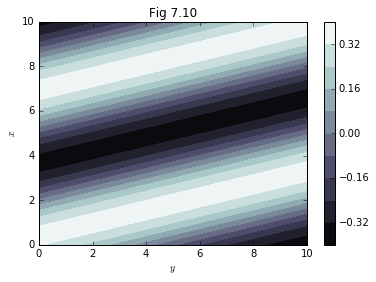

In [12]:
grid=np.linspace(0,10,200)
u=turn_band_simple(grid,grid)
#
ax = plt.gca()
#ax.plot_wireframe(T,X,ut,rstride=16,cstride=1000,colors='k')
CS=ax.contourf(grid,grid,u,10,cmap=plt.cm.bone)
#ax.set_zlabel(r'$u$')
s=ax.set_xlabel(r'$y$')
s=ax.set_ylabel(r'$x$')
s=ax.set_title(r'Fig 7.10')
s=plt.colorbar(CS)

Let's average over multiple realisations.

In [13]:
def turn_band_simple2(grid1,grid2,M):
    """
    A7.9 Page 289
    """
    xx,yy=np.meshgrid(grid1,grid2)
    sum=np.zeros(xx.size)
    for j in range(M):
        xi=np.random.randn(2)
        theta=pi * j / M
        e=np.array([cos(theta),sin(theta)])
        tmp=np.vstack([xx.ravel(),yy.ravel()])
        tt=np.dot(e,tmp)
        v=sqrt(1 / 2) * np.dot(xi,np.vstack([np.cos(tt),np.sin(tt)]))
        sum=sum + v
    v=sum / sqrt(M)
    v=v.reshape((grid1.size,grid2.size))
    return v

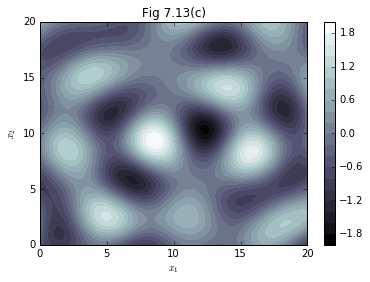

In [14]:
grid=np.linspace(0,20,200)
u=turn_band_simple2(grid,grid,10)
#
ax = plt.gca()
#ax.plot_wireframe(T,X,ut,rstride=16,cstride=1000,colors='k')
CS=ax.contourf(grid,grid,u,20,cmap=plt.cm.bone)
#ax.set_zlabel(r'$u$')
s=ax.set_xlabel(r'$x_1$')
s=ax.set_ylabel(r'$x_2$')
s=ax.set_title(r'Fig 7.13(c)')
s=plt.colorbar(CS)

The turning-bands technique can be coupled with the methods from Chapter 6 to sample the stationary Gaussian random field with the Whittle-Matern covariance.

In [15]:
import ch6
def turn_band_wm(grid1,grid2,M,q,ell):
    """
    A7.10 Page 291
    """
    xx,yy=np.meshgrid(grid1,grid2)
    sum=np.zeros(xx.size)
    T=np.linalg.norm([np.linalg.norm(grid1,np.inf),
                      np.linalg.norm(grid2,np.inf)])
    for j in range(M):
        theta=j * pi / M
        e=np.array([cos(theta),sin(theta)])
        tmp=np.vstack([xx.ravel(),yy.ravel()])
        tt=np.dot(e,tmp)
        gridt,Z=ch6.squad(2 * T,64,64,lambda s: ff(s,q,ell))
        Xi=np.interp(tt,gridt - T,np.real(Z))
        sum=sum + Xi
    u=sum / sqrt(M)
    u=u.reshape(grid1.size,grid2.size)
    return u
@jit([f8(f8,f8,f8)])
def ff(s,q,ell):
    f=gamma(q + 1) / gamma(q) * (ell ** 2 * abs(s)) / (1 + (ell * s) ** 2) ** (q + 1)
    return f

Here's a realisation.

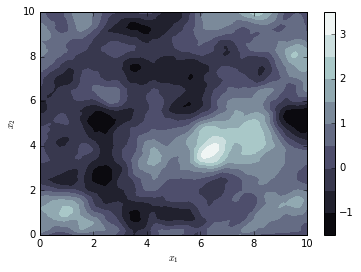

In [16]:
grid=np.linspace(0,10,200)
u=turn_band_wm(grid,grid,10,1,1)
#
ax = plt.gca()
#ax.plot_wireframe(T,X,ut,rstride=16,cstride=1000,colors='k')
CS=ax.contourf(grid,grid,u,10,cmap=plt.cm.bone)
#ax.set_zlabel(r'$u$')
s=ax.set_xlabel(r'$x_1$')
s=ax.set_ylabel(r'$x_2$')
s=plt.colorbar(CS)